---
## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import create_sample, show_plot, multi_step_plot
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

---
## Загрузка данных

In [2]:
df = pd.read_csv('weather_data_1989_1996.csv')

In [3]:
df.head()

,datetime,temperature,lighting,humidity,pressure
0,1989-01-01 00:00:00,-14.01,-1.00,0.79,790.06
1,1989-01-01 00:30:00,-14.00,-1.00,0.78,789.58
2,1989-01-01 01:00:00,-13.98,-1.00,0.64,783.14
3,1989-01-01 01:30:00,-13.93,-1.00,0.76,788.52
4,1989-01-01 02:00:00,-13.87,-0.99,0.74,787.48


In [4]:
temperature = df.temperature.to_numpy()

In [5]:
temperature.shape

(122640,)

In [6]:
data_uni, target_uni = create_sample(temperature)
print(f'data shape:{data_uni.shape}\ntarget shape: {target_uni.shape}')

data shape:(122634, 5, 1)
target shape: (122634, 1)


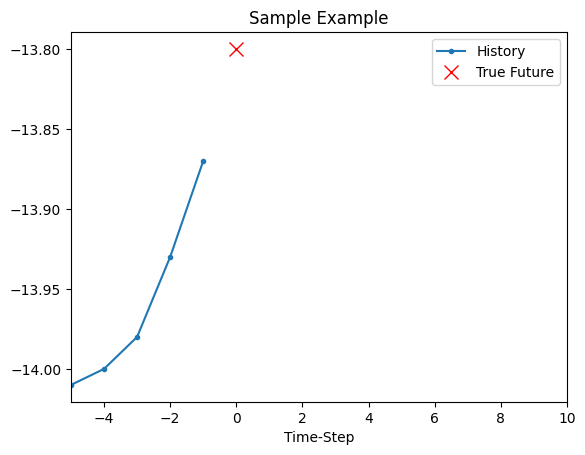

In [7]:
plot = show_plot([data_uni[0], target_uni[0]])

---
## Построение нейросети

## 1. Точечное прогнозирование

In [8]:
tf.random.set_seed(2023)

In [9]:
TRAIN_SPLIT = 80000

uni_input_lag = 20
uni_duration = 1
# Тестовая
x_train_uni, y_train_uni = create_sample(timeseries=temperature, begin=0, end=TRAIN_SPLIT, input_lag=uni_input_lag, duration=uni_duration)
# Валидационая
x_val_uni, y_val_uni = create_sample(timeseries=temperature, begin=TRAIN_SPLIT, end=None, input_lag=uni_input_lag, duration=uni_duration)

In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [11]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [12]:
# Проверим выход модели
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 3ms/step
(256, 1)


In [13]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 10ms/step - loss: 11.8157 - val_loss: 6.0227
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 8.3821 - val_loss: 3.4026
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 6.2003 - val_loss: 1.7172
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 4.6915 - val_loss: 0.9544
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6948 - val_loss: 0.3663
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 2.2732 - val_loss: 0.1300
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 1.3106 - val_loss: 0.0504
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6211 - val_loss: 0.0472
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7190 - val_loss: 0.0211
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3375 - val_loss: 0.02

### Несколько прогнозов

8/8 [==============================] - 0s 2ms/step


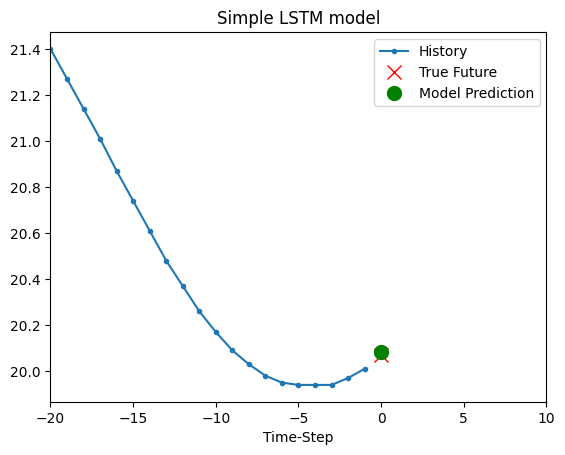

8/8 [==============================] - 0s 3ms/step


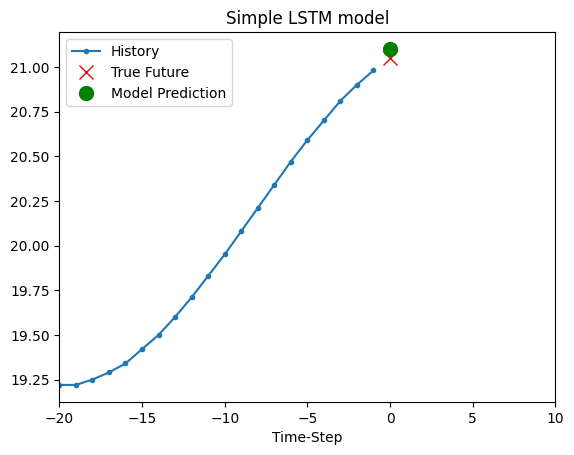

8/8 [==============================] - 0s 3ms/step


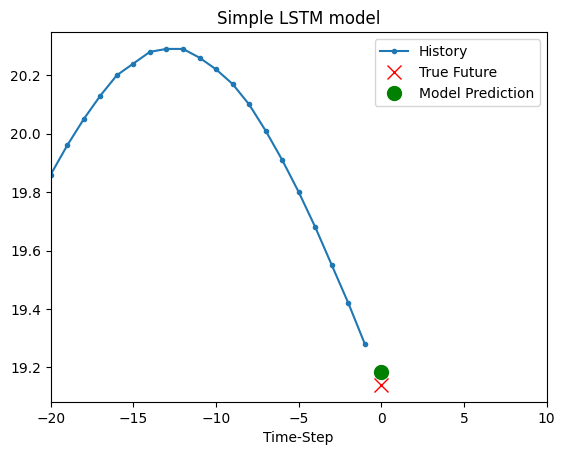

In [14]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## 2. Интервальное прогнозирование

In [15]:
TRAIN_SPLIT = 80000

mul_input_lag = 80
mul_duration = 20
# Тестовая
x_train_mul, y_train_mul = create_sample(timeseries=temperature, begin=0, end=TRAIN_SPLIT, input_lag=mul_input_lag, duration=mul_duration)
# Валидационая
x_val_mul, y_val_mul = create_sample(timeseries=temperature, begin=TRAIN_SPLIT, end=None, input_lag=mul_input_lag, duration=mul_duration)

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_multivariate = tf.data.Dataset.from_tensor_slices((x_train_mul, y_train_mul))
train_multivariate = train_multivariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_multivariate = tf.data.Dataset.from_tensor_slices((x_val_mul, y_val_mul))
val_multivariate = val_multivariate.batch(BATCH_SIZE).repeat()

In [17]:
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_mul.shape[-2:]),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(20)
])

multi_step_model.compile(optimizer='rmsprop', loss='mae')

In [18]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history_mul = multi_step_model.fit(train_multivariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_multivariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 91s 438ms/step - loss: 5.3879 - val_loss: 2.4082
Epoch 2/10
200/200 [==============================] - 87s 435ms/step - loss: 1.6993 - val_loss: 0.9521
Epoch 3/10
200/200 [==============================] - 83s 415ms/step - loss: 2553.2603 - val_loss: 4369.5483
Epoch 4/10
200/200 [==============================] - 96s 479ms/step - loss: 1623.0312 - val_loss: 1099.4408
Epoch 5/10
200/200 [==============================] - 106s 531ms/step - loss: 435.9735 - val_loss: 167.3323
Epoch 6/10
200/200 [==============================] - 87s 434ms/step - loss: 93.1689 - val_loss: 75.3321
Epoch 7/10
200/200 [==============================] - 88s 440ms/step - loss: 56.4123 - val_loss: 129.2904
Epoch 8/10
200/200 [==============================] - 84s 419ms/step - loss: 60.2433 - val_loss: 17.0384
Epoch 9/10
200/200 [==============================] - 91s 456ms/step - loss: 19.9879 - val_loss: 33.5291
Epoch 10/10
200/200 [==========================

---
### Несколько прогнозов

8/8 [==============================] - 1s 32ms/step


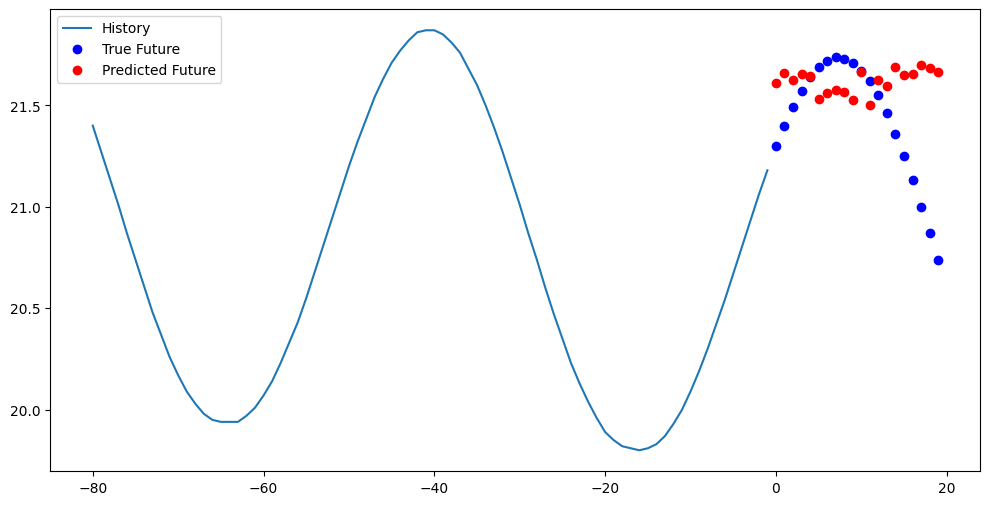

8/8 [==============================] - 0s 34ms/step


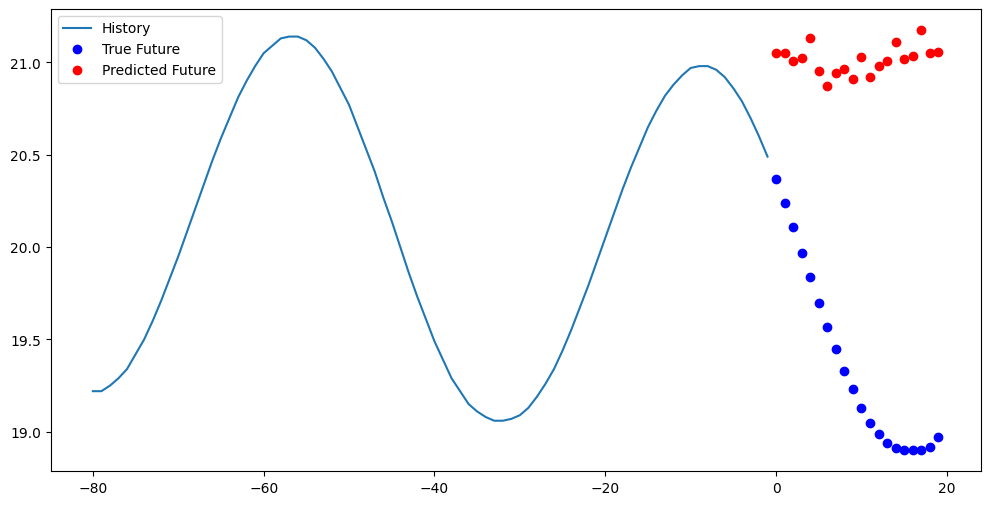

8/8 [==============================] - 0s 35ms/step


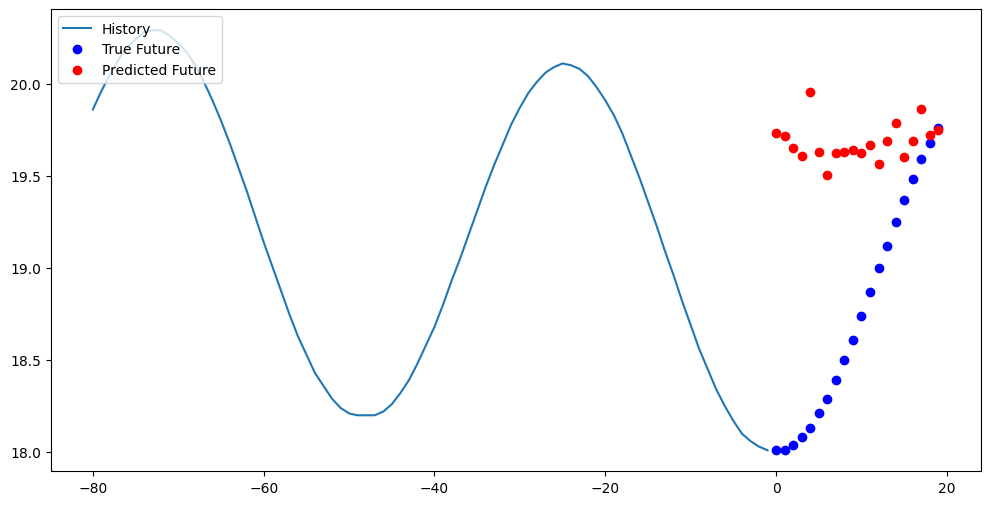

In [19]:
for x, y in val_multivariate.take(3):
    plot = multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
    plot.show()